Unzipping the contents

In [4]:
!unzip -qq /content/drive/MyDrive/stumbleupon.zip
!pip -qq install transformers

Importing necessary libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option("display.max_colwidth", 200) 


# basic NLP libraries
import re
import nltk
import warnings
#ignore warning
warnings.filterwarnings("ignore") 


# importing models
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn import svm


# imporing libraries for preprocessing and evaluation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report


from wordcloud import WordCloud, STOPWORDS
from tqdm import tqdm
import tensorflow as tf
import scipy

Reading and cleaning the dataset

In [6]:
# reading
train = pd.read_csv('/content/train.tsv', sep='\t')
test = pd.read_csv('/content/test.tsv', sep='\t') 

# cleaning the text data
data = train.append(test)
data['label'].fillna(-1, inplace = True)
data['boilerplate'].replace(to_replace = r'"title":', value = "", inplace = True, regex = True)
data['boilerplate'].replace(to_replace =r'"url":', value = "", inplace = True, regex = True)
data['boilerplate'].replace(to_replace = r'{|}', value = "", inplace = True, regex = True)
data['boilerplate'] = data['boilerplate'].str.lower()

In [7]:
def createWordCloud(target):
    df = pd.DataFrame()
    if target == -1:
        df = data
    else:
        df = data[data['label'] == target]
    
    words = " ".join(df['boilerplate'])
    wc = WordCloud(stopwords = STOPWORDS, 
                   background_color = 'black', 
                   width=1500, height=1000).generate(words)
    plt.figure(figsize = (10, 10))
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

def createPieChart(df):
    temp = 100 * df.value_counts() / len(df)
    labels = df.value_counts().index.values
    sizes = temp 
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.2f%%', shadow=True, startangle=90)
    ax1.axis('equal')
    plt.show

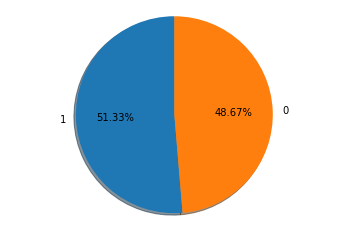

In [8]:
createPieChart(train.label)

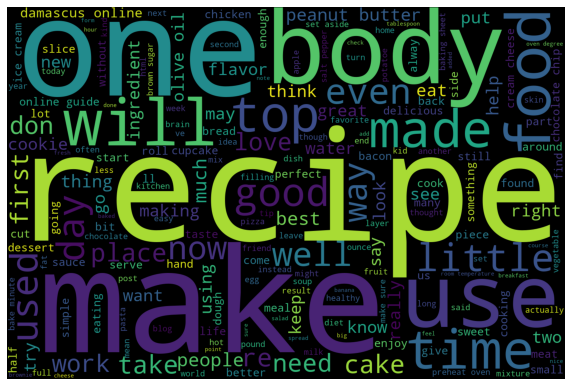

In [9]:
createWordCloud(1)

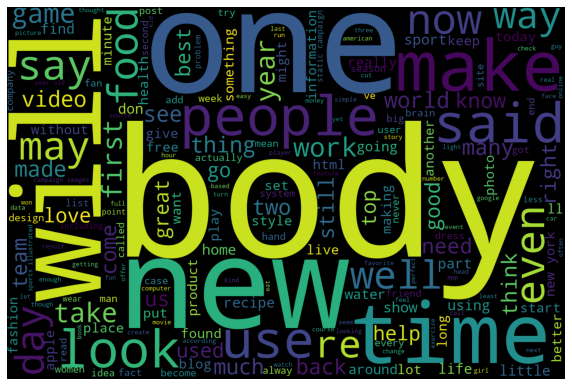

In [10]:
createWordCloud(0)

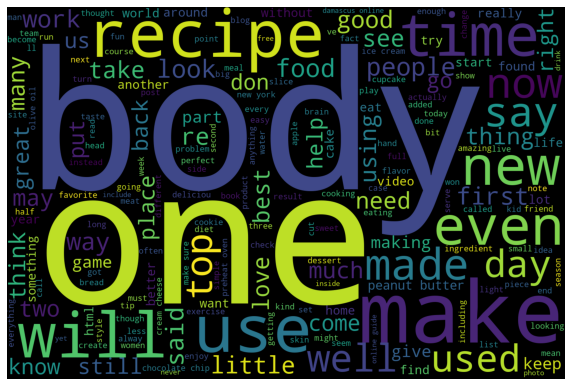

In [11]:
createWordCloud(-1)

In [12]:
trainfull = data[data.label != -1]
test = data[data.label == -1]
train, val = train_test_split(trainfull, test_size = 0.2, random_state = 42)

train_set = []
for words in tqdm(train.boilerplate):
    train_set.append(words)

val_set = []
for words in tqdm(val.boilerplate):
    val_set.append(words)

test_set = []
for words in tqdm(test.boilerplate):
    test_set.append(words)

train_full = []
for words in tqdm(trainfull.boilerplate):
    train_full.append(words)

100%|██████████| 7395/7395 [00:00<00:00, 895277.19it/s]


In [13]:
vectorizer = TfidfVectorizer(
                                  min_df=3,  
                                  max_features=None, 
                                  strip_accents='unicode',  
                                  analyzer='word',
                                  token_pattern=r'\w{1,}',
                                  ngram_range=(1, 2), 
                                  use_idf=1,
                                  smooth_idf=1,
                                  sublinear_tf=1
                             )

train_data = vectorizer.fit_transform(train_set)
val_data = vectorizer.transform(val_set)
test_data = vectorizer.transform(test_set)
train_full = vectorizer.transform(train_full)


In [14]:
# let's look at the dataframe

train_df = pd.DataFrame(train_data.toarray(), columns = vectorizer.get_feature_names())
train_df.head()

,0,0 0,0 08,0 1,0 10,0 10px,0 14,0 15,0 16,0 17,0 2,0 20,0 20px,0 22,0 25,0 26,0 2817,0 2933,0 3,0 30,0 32,0 33,0 34,0 38,0 39,0 4,0 41,0 45,0 46,0 48,0 5,0 50,0 55,0 56,0 5px,0 6,0 61,0 63,0 66,0 68,...,zoe,zojirushi,zombie,zombie apocalypse,zombie the,zone,zone and,zone as,zone out,zone sports,zones,zones and,zoo,zoom,zoom 1,zoom in,zoom yummy,zooming,zooming in,zoomyummy,zu,zucchini,zucchini 1,zucchini and,zucchini body,zucchini bread,zucchini in,zucchini is,zucchini or,zucchini recipe,zucchini sliced,zucchini slices,zucchini the,zucchini to,zucchini with,zuckerberg,zumba,zur,zurich,zurich switzerland
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
clfs = [
          LogisticRegression(),
          MultinomialNB(), 
          DecisionTreeClassifier(),
          RandomForestClassifier(n_estimators = 1000, random_state = 42),
          KNeighborsClassifier(n_neighbors = 51),
          XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3),
          svm.SVC(probability=True)
       ]

clfs_name = []
val_preds = []
full_preds = []
preds = []

# Training 

In [16]:
for clf in clfs:
    model = clf.fit(train_data, train.label)
    preds.append(model.predict_proba(test_data))  
    val_pred = model.predict_proba(val_data)
    val_preds.append(val_pred)
    full_pred = model.predict_proba(train_full)
    full_preds.append(full_pred)
    acc = round(100*accuracy_score(model.predict(val_data), val.label), 2)
    print("\n", clf.__class__.__name__, "\nACCURACY", acc, "\n")


 LogisticRegression 
ACCURACY 80.32 


 MultinomialNB 
ACCURACY 79.92 


 DecisionTreeClassifier 
ACCURACY 70.66 


 RandomForestClassifier 
ACCURACY 80.26 


 KNeighborsClassifier 
ACCURACY 81.95 


 XGBClassifier 
ACCURACY 79.04 


 SVC 
ACCURACY 79.92 



In [17]:
# Skipping Decision Tree preds as it was not upto the mark in my opinion

testpred = (preds[0][:, -1]+ preds[1][:, -1]+ preds[6][:, -1]+ preds[3][:, -1]+ preds[4][:, -1]+ preds[5][:, -1]) / 6
valpred = (val_preds[0][:, -1]+ val_preds[1][:, -1]+ val_preds[6][:, -1]+ val_preds[3][:, -1]+ val_preds[4][:, -1]+ val_preds[5][:, -1]) / 6
fullpred = (full_preds[0][:, -1]+ full_preds[1][:, -1]+ full_preds[6][:, -1]+ full_preds[3][:, -1]+ full_preds[4][:, -1]+ full_preds[5][:, -1]) / 6

fullpred = np.round(fullpred)
valpred = np.round(valpred)

# Weighted average of above predictions

In [20]:
testfile = pd.read_csv('/content/test.tsv', sep="\t", na_values=['?'], index_col=1)
pred_df = pd.DataFrame(testpred, index=testfile.index, columns=['label'])
pred_df.to_csv('ensemble.csv')

In [21]:
import gc
gc.collect()

8979

# Transformer Model Inference

In [22]:
reloaded = tf.saved_model.load('/content/drive/MyDrive/transformer/content/transformer')
print(list(reloaded.signatures.keys()))

infer = reloaded.signatures["serving_default"]
print(infer.structured_outputs)

['serving_default']
{'dense_1': TensorSpec(shape=(None, 1), dtype=tf.float32, name='dense_1')}


In [23]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

temp = 512

# for train set
Xids = np.zeros((train.shape[0], temp))
Xmask = np.zeros((train.shape[0], temp))
y = np.zeros((train.shape[0], 1))


# for test set
Xids_test = np.zeros((test.shape[0], temp))
Xmask_test = np.zeros((test.shape[0], temp))

# Tokenization

In [24]:
for i, sequence in enumerate(train['boilerplate']):
    tokens = tokenizer.encode_plus(
                                        sequence,
                                        max_length = temp,
                                        padding = 'max_length',
                                        add_special_tokens = True,
                                        truncation = True,
                                        return_token_type_ids = False,
                                        return_attention_mask = True,
                                        return_tensors = 'tf'
                                   )
    
    Xids[i, :], Xmask[i, :], y[i, 0] = tokens['input_ids'], tokens['attention_mask'], train.iloc[i, -1]

In [25]:
for i, sequence in enumerate(test['boilerplate']):
    tokens = tokenizer.encode_plus(
                                        sequence,
                                        max_length=512,
                                        padding='max_length',
                                        add_special_tokens=True,
                                        truncation=True,
                                        return_token_type_ids=False,
                                        return_attention_mask=True,
                                        return_tensors='tf'
                                   )
    
    Xids_test[i, :], Xmask_test[i, :] = tokens['input_ids'], tokens['attention_mask']

# Transformer Inference

In [26]:
newarr_Xids_test = np.array_split(Xids_test, 100)
newarr_Xmask_test = np.array_split(Xmask_test, 100)


pred_temp_test = []
predlist_test = []
predictions_TF_test = []


def map_func(input_ids, mask):
    return {'input_ids':input_ids,'attention_mask':mask}

for i in tqdm(range(len(newarr_Xids_test))):
    dataset_test = tf.data.Dataset.from_tensor_slices((newarr_Xids_test[i], newarr_Xmask_test[i]))
    dataset_test = dataset_test.map(map_func)
    dataset_test = dataset_test.batch(35).prefetch(1000)

    sample = next(iter(dataset_test))
    x = sample['input_ids']
    x = tf.dtypes.cast(x, tf.int32)
    y = sample['attention_mask']
    y = tf.dtypes.cast(y, tf.int32)


    labeling = infer(input_ids = x, attention_mask = y)
    pred_temp_test.append(labeling)

100%|██████████| 100/100 [49:13<00:00, 29.53s/it]


In [27]:
# making a 1D list suitable for working with

for i in range(len(pred_temp_test)):
    predlist_test.append(pred_temp_test[i]['dense_1'].numpy())

for i in range(len(predlist_test)):
    for ii in range(len(predlist_test[i])):
        predictions_TF_test.append(predlist_test[i][ii][0])

# Stats of the Prediction

In [28]:
scipy.stats.describe(predictions_TF_test)

DescribeResult(nobs=3171, minmax=(0.052856922, 0.97692734), mean=0.5138817, variance=0.09582645, skewness=0.17123140394687653, kurtosis=-1.6232960342231564)

# Transformer Prediction to CSV

In [29]:
testfile = pd.read_csv('/content/test.tsv', sep="\t", na_values=['?'], index_col = 1)
pred_df = pd.DataFrame(predictions_TF_test, index = testfile.index, columns=['label'])
pred_df.to_csv('transformer.csv')

# Further Taking averages of both the output files

In [33]:
df1 = pd.read_csv('/content/ensemble.csv')
df2 = pd.read_csv('/content/transformer.csv')

df = pd.DataFrame()
df['urlid'] = df1['urlid']
df['label'] = (df1['label'] + df2['label'])/2

In [34]:
df.to_csv('submit.csv', index = False)

# Precision and Recall for each class

In [40]:
print(classification_report(fullpred, trainfull.label))

              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92      3724
         1.0       0.91      0.94      0.92      3671

    accuracy                           0.92      7395
   macro avg       0.92      0.92      0.92      7395
weighted avg       0.92      0.92      0.92      7395

